# Chance-Constrained Active Inference

This notebook applies reactive message passing for active inference in the context of chance-constraints. The implementation is based on (van de Laar et al., 2021, "Chance-constrained active inference")
and [discussion](https://discourse.julialang.org/t/use-of-update-in-rxinfer-to-handle-multiple-iterations) with John Boik.

We consider a 1-D agent that tries to elevate itself above ground level. Instead of a goal prior, we impose a chance constraint on future states, such that the agent prefers to avoid the ground with a preset probability (chance) level. 

In [1]:
using Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In [2]:
using Plots, Distributions, StatsFuns, RxInfer

## Chance-Constraint Node Definition

A chance-constraint is meant to constraint a marginal distribution to abide by certain properties. In this case, a (posterior) probability distribution should not "overflow" a given region by more than a certain probability mass. This constraint then affects adjacent beliefs and ultimately the controls to (hopefully) account for the imposed constraint.

In order to enforce this constraint on a marginal distribution, an auxiliary chance-constraint node is included in the graphical model. This node then sends messages that enforce the marginal to abide by the preset conditions. In other words, the (chance) constraint on the (posterior) marginal, is converted to a prior constraint on the generative model that sends an adaptive message. We start by defining this chance-constraint node and its message.

In [3]:
struct ChanceConstraint end  

# Node definition with safe region limits (lo, hi), overflow chance epsilon and tolerance atol
@node ChanceConstraint Stochastic [out, lo, hi, epsilon, atol]

In [4]:
# Function to compute normalizing constant and central moments of a truncated Gaussian distribution
function truncatedGaussianMoments(m::Float64, V::Float64, a::Float64, b::Float64)
    V = clamp(V, tiny, huge)
    StdG = Distributions.Normal(m, sqrt(V))
    TrG = Distributions.Truncated(StdG, a, b)
    
    Z = Distributions.cdf(StdG, b) - Distributions.cdf(StdG, a)  # safe mass for standard Gaussian
    
    if Z < tiny
        # Invalid region; return undefined mean and variance of truncated distribution
        Z    = 0.0
        m_tr = 0.0
        V_tr = 0.0
    else
        m_tr = Distributions.mean(TrG)
        V_tr = Distributions.var(TrG)
    end
    
    return (Z, m_tr, V_tr)
end;

In [5]:
@rule ChanceConstraint(:out, Marginalisation) (
    m_out::UnivariateNormalDistributionsFamily, # Require inbound message
    q_lo::PointMass, 
    q_hi::PointMass, 
    q_epsilon::PointMass, 
    q_atol::PointMass) = begin 

    # Extract parameters
    lo = mean(q_lo)
    hi = mean(q_hi)
    epsilon = mean(q_epsilon)
    atol = mean(q_atol)
    
    (m_bw, V_bw) = mean_var(m_out)
    (xi_bw, W_bw) = (m_bw, 1. /V_bw)  # check division by  zero
    (m_tilde, V_tilde) = (m_bw, V_bw)
    
    # Compute statistics (and normalizing constant) of q in safe region G
    # Phi_G is called the "safe mass" 
    (Phi_G, m_G, V_G) = truncatedGaussianMoments(m_bw, V_bw, lo, hi)

    xi_fw = xi_bw
    W_fw  = W_bw
    if epsilon <= 1.0 - Phi_G # If constraint is active
        # Initialize statistics of uncorrected belief
        m_tilde = m_bw
        V_tilde = V_bw
        for i = 1:100 # Iterate at most this many times
            (Phi_lG, m_lG, V_lG) = truncatedGaussianMoments(m_tilde, V_tilde, -Inf, lo) # Statistics for q in region left of G
            (Phi_rG, m_rG, V_rG) = truncatedGaussianMoments(m_tilde, V_tilde, hi, Inf) # Statistics for q in region right of G

            # Compute moments of non-G region as a mixture of left and right truncations
            Phi_nG = Phi_lG + Phi_rG
            m_nG = Phi_lG / Phi_nG * m_lG + Phi_rG / Phi_nG * m_rG
            V_nG = Phi_lG / Phi_nG * (V_lG + m_lG^2) + Phi_rG/Phi_nG * (V_rG + m_rG^2) - m_nG^2

            # Compute moments of corrected belief as a mixture of G and non-G regions
            m_tilde = (1.0 - epsilon) * m_G + epsilon * m_nG
            V_tilde = (1.0 - epsilon) * (V_G + m_G^2) + epsilon * (V_nG + m_nG^2) - m_tilde^2
            # Re-compute statistics (and normalizing constant) of corrected belief
            (Phi_G, m_G, V_G) = truncatedGaussianMoments(m_tilde, V_tilde, lo, hi)
            if (1.0 - Phi_G) < (1.0 + atol)*epsilon
                break # Break the loop if the belief is sufficiently corrected
            end
        end
        
        # Convert moments of corrected belief to canonical form
        W_tilde = inv(V_tilde)
        xi_tilde = W_tilde * m_tilde

        # Compute canonical parameters of forward message
        xi_fw = xi_tilde - xi_bw
        W_fw  = W_tilde - W_bw
    end

    return NormalWeightedMeanPrecision(xi_fw, W_fw)
end

## Definition of the Environment

We consider an environment where the agent has an elevation level, and where the agent directly controls its vertical velocity. After some time, an unexpected and sudden gust of wind tries to push the agent to the ground.

In [6]:
wind(t::Int64) = -0.1*(60 <= t < 100) # Time-dependent wind profile

function initializeWorld()
    x_0 = 0.0 # Initial elevation
    
    x_t_last = x_0
    function execute(t::Int64, a_t::Float64)
        x_t = x_t_last + a_t + wind(t) # Update elevation
    
        x_t_last = x_t # Reset state
                
        return x_t
    end

    x_t = x_0 # Predefine outcome variable
    observe() = x_t # State is fully observed

    return (execute, observe)
end;

## Generative Model for Regulator

We consider a fully observed Markov decision process, where the agent directly observes the true state (elevation) of the world. In this case we only need to define a chance-constrained generative model of future states. Inference for controls on this model then derives our controller.

In [7]:
@model function regulator_model(; T, lo, hi, epsilon, atol)
    # Fully observed state
    x_t = datavar(Float64)

    # Control prior statistics
    m_u = datavar(Float64, T)
    v_u = datavar(Float64, T)    
        
    # Random variables
    u = randomvar(T) # Control
    x = randomvar(T) # Elevation
    
    # Loop over horizon
    x_k_last = x_t
    for k = 1:T
        u[k] ~ NormalMeanVariance(m_u[k], v_u[k]) # Control prior
        x[k] ~ x_k_last + u[k] # Transition model
        x[k] ~ ChanceConstraint(lo, hi, epsilon, atol) where { # Simultaneous constraint on state
            pipeline = RequireMessage(out = NormalWeightedMeanPrecision(0, 0.01))} # Predefine inbound message to break circular dependency
        x_k_last = x[k]
    end
    
    return (u, x)
end

## Reactive Agent Definition

In [8]:
function initializeAgent()
    # Set control prior statistics
    m_u = zeros(T)
    v_u = lambda^(-1)*ones(T)
    
    function infer(x_t::Float64)
        model_t = regulator_model(; T=T, lo=lo, hi=hi, epsilon=epsilon, atol=atol)
        data_t = (m_u = m_u, v_u = v_u, x_t = x_t)
        
        result = inference(
            model = model_t, 
            data = data_t,
            iterations = n_its)

        # Extract policy from inference results
        pol = mode.(result.posteriors[:u][end])

        return pol
    end

    pol = zeros(T) # Predefine policy variable
    act() = pol[1]

    return (infer, act)
end;

## Action-Perception Cycle

Next we define and execute the action-perception cycle. Because the state is fully observed, these is no slide (estimator) step in the cycle. 

In [9]:
# Simulation parameters
N = 160 # Total simulation time
T = 1 # Lookahead time horizon
lambda = 1.0 # Control prior precision
lo = 1.0 # Chance region lower bound
hi = Inf # Chance region upper bound
epsilon = 0.01 # Allowed chance violation
atol = 0.01 # Convergence tolerance for chance constraints
n_its = 10;  # Number of inference iterations

In [10]:
(execute, observe) = initializeWorld() # Let there be a world
(infer, act) = initializeAgent() # Let there be an agent

a = Vector{Float64}(undef, N) # Actions
x = Vector{Float64}(undef, N) # States
for t = 1:N
    a[t] = act()
           execute(t, a[t])
    x[t] = observe()
           infer(x[t])
end

## Results

Results show that the agent does not allow the wind to push it all the way to the ground.

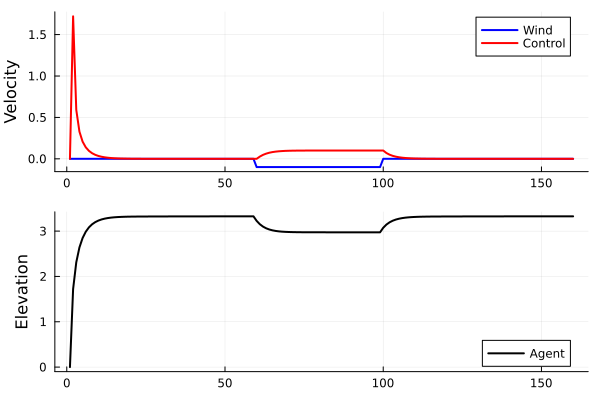

In [11]:
p1 = plot(1:N, wind.(1:N), color="blue", label="Wind", ylabel="Velocity", lw=2)
plot!(p1, 1:N, a, color="red", label="Control", lw=2)
p2 = plot(1:N, x, color="black", lw=2, label="Agent", ylabel="Elevation")
plot(p1, p2, layout=(2,1))